# Global indicator project - Phoenix, Arizona
  

### What counts as frequent [transport](https://public.3.basecamp.com/p/fn7G4ebUaoCNgqpadpSVUe5S): 
[gtfs](https://developers.google.com/transit/gtfs/reference/#routestxt) reference
- Which stops qualify on a daily basis?  
-- First service departs before 7.30am  
-- Last service departs on or after 6.30pm  
-- Has a maximum inter-departure time less than or equal to 30 minutes  

It is difficult (especially in some cities) to determine what constitutes a “normal weekday” – some modes run different timetables on different weekdays, and timetable changes are introduced frequently.

- How do we define a “normal weekday”?  
-- Exclude dates outside 2018 school term 4 weekdays  
-- For dates during term 4 for which timetable data is fully available, identify stops meeting the frequency criteria on each and every one of these days  
-- Stops that are “frequent” stops on 90% or more of these dates (i.e. we don’t look specifically at public holidays) are deemed to be “frequent” stops on a “normal weekday”  


In [1]:
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape,Point, LineString, Polygon
import config

import warnings
warnings.filterwarnings(action='once')

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

## Set up configuration 

In [2]:
suffix = config.time

for place in config.places.values():
    place = place

# configure filenames to save/load POI and network datasets
OSM_folder = config.OSM_data_loc
gtfs_folder = config.gtfs_data_loc
G_filename = '{studyregion}_walk{suffix}.graphml'.format(studyregion = place, suffix = config.time)

## Load the metro stop 
GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [3]:
gtfs_stops = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/stops.txt')
gdf_stops = gpd.GeoDataFrame(gtfs_stops)

In [4]:
#define geometry
gdf_stops[['stop_lat', 'stop_lon']]  = gdf_stops[['stop_lat', 'stop_lon']].astype(float)
gdf_stops['geometry'] = gdf_stops.apply(lambda row: Point((row['stop_lon'], row['stop_lat'])), axis=1)

## Load the metro stop_times.txt

In [5]:
gtfs_stop_times = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/stop_times.txt')
gdf_stop_times = gpd.GeoDataFrame(gtfs_stop_times)

/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### merge stop id with trip id

In [6]:
stop_trip = pd.merge(gdf_stops, gdf_stop_times, how='inner', on='stop_id')

## Load the metro trips.txt

In [7]:
gtfs_trips = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/trips.txt')
gdf_trips = gpd.GeoDataFrame(gtfs_trips)

### merge with trips

In [8]:
stop_trip_route = pd.merge(stop_trip, gdf_trips, how='inner', on='trip_id')

In [10]:
stop_trip_route.set_index('stop_id').loc['100', 'arrival_time': 'departure_time']

,arrival_time,departure_time
stop_id,,
100,04:17:00,04:17:00
100,04:47:00,04:47:00
100,05:17:00,05:17:00
100,23:47:00,23:47:00
100,22:47:00,22:47:00
100,24:47:00,24:47:00
100,24:17:00,24:17:00
100,23:17:00,23:17:00


## Load the metro routes.txt

In [12]:
gtfs_routes = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/routes.txt')
gdf_routes = gpd.GeoDataFrame(gtfs_routes)

### merge with routes 

In [13]:
stop_trip_route_type = pd.merge(stop_trip_route, gdf_routes, how='inner', on='route_id')

In [14]:
stop_trip_route_type['route_type'].value_counts()

3    65528
0        8
Name: route_type, dtype: int64

### Load the calendar.txt

In [15]:
gtfs_calendar = pd.read_csv(gtfs_folder + '/' + 'gtfs_phx/calendar.txt')
gdf_calendar = gpd.GeoDataFrame(gtfs_calendar)



In [16]:
stop_trip_route_type_calendar = pd.merge(stop_trip_route_type, gdf_calendar, how='inner', on='service_id')

In [18]:
stop_trip_route_type_calendar.columns

Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'geometry', 'trip_id', 'arrival_time', 'departure_time',
       'stop_sequence', 'pickup_type', 'drop_off_type', 'timepoint',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'block_id',
       'shape_id', 'route_short_name', 'route_long_name', 'route_desc',
       'route_type', 'route_url', 'monday', 'tuesday', 'wednesday', 'thursday',
       'friday', 'saturday', 'sunday', 'start_date', 'end_date'],
      dtype='object')

In [22]:
stop_trip_route_type_calendar[['stop_id', 'route_id', 'trip_id', 'arrival_time', 'departure_time', 'monday', 'tuesday', 'wednesday', 'thursday', 'service_id']].sort_values(by='stop_id')

,stop_id,route_id,trip_id,arrival_time,departure_time,monday,tuesday,wednesday,thursday,service_id
0,100,170,425902436,04:17:00,04:17:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
148,100,170,425902439,23:47:00,23:47:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
202,100,170,425902440,22:47:00,22:47:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
256,100,170,425902441,24:47:00,24:47:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
310,100,170,425902443,24:17:00,24:17:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
364,100,170,425902444,23:17:00,23:17:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
94,100,170,425902438,05:17:00,05:17:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
40,100,170,425902437,04:47:00,04:47:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
1044,1003,52,425901605,22:19:00,22:19:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01
1009,1003,52,425901603,24:19:00,24:19:00,1,1,1,1,PHJA19-PHX-NS-M-Tu-W-Th-01


## Load the OSM streetnetwork graph using OSMnx

In [ ]:
G_osm_walk = ox.load_graphml(G_filename, folder = OSM_folder)
gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)

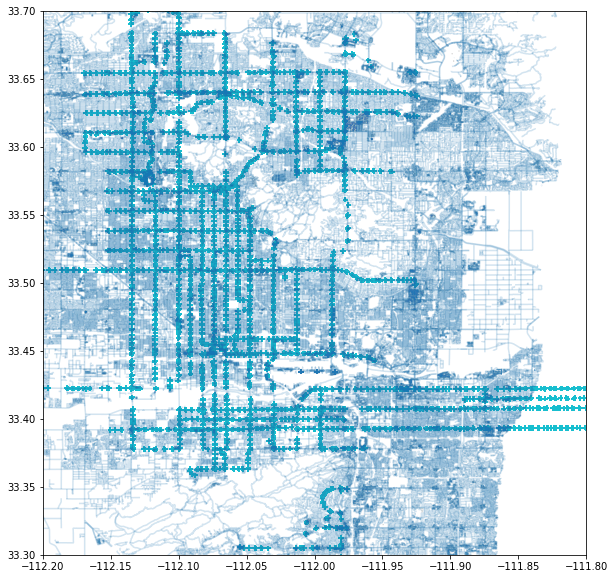

In [26]:

#plot metro stops with OSM all street network
fig, ax = plt.subplots(figsize=(10, 10))
ax = gdf_osm_walk_edges.plot(ax=ax, alpha=0.1)
ax = stop_trip_route_type.plot(ax=ax, categorical=True, column='route_type', marker='+', markersize=30)
ax.set_ylim((33.3,33.7))
ax.set_xlim((-112.2, -111.8))
#ax.set_axis_off()
#fig.suptitle('Meto stops', fontsize=14, fontweight='bold')
#fig.text(0.1, 0, 'Note: OSM street network')
plt.show()